# Robustness Experiment Tutorial

## General

This notebook shows examples how to use the different components of ada-verona. 
If these experiments are executed in a non-notebook context, one can make use of the ExperimentRepostory class to 
create and organise experiments in a structured manner. However, because this notebook shall show just the components 
and their input / output it does not make use of the ExperimentRepository class.
To see examples on how to use it, one can take a look at the example scripts in the scripts/ folder.

## Importing Necessary Components

In [1]:
import logging
from datetime import datetime
from pathlib import Path

import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from autoverify.verifier import Nnenum
from ada_verona.database.machine_learning_model.network import Network
from ada_verona.database.machine_learning_model.onnx_network import ONNXNetwork
from ada_verona.database.machine_learning_model.pytorch_network import PyTorchNetwork

from ada_verona.analysis.report_creator import ReportCreator
from ada_verona.database.dataset.image_file_dataset import ImageFileDataset
from ada_verona.database.dataset.pytorch_experiment_dataset import PytorchExperimentDataset
from ada_verona.database.verification_context import VerificationContext
from ada_verona.dataset_sampler.predictions_based_sampler import PredictionsBasedSampler
from ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator import (
    BinarySearchEpsilonValueEstimator,
)
from ada_verona.verification_module.auto_verify_module import (
    AutoVerifyModule,
)
from ada_verona.verification_module.property_generator.one2any_property_generator import (
    One2AnyPropertyGenerator,
)

%matplotlib inline
torch.manual_seed(0)
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", level=logging.DEBUG)

DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='Erf', version=13)
DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='Erf', version=9)
DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='HardSigmoid', version=6)
DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='HardSigmoid', version=1)
DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='HardSwish', version=14)
DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='LeakyRelu', version=16)
DEBUG:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='LeakyRelu', version=

## Defining Dataset

In [2]:
# define pytorch dataset. Preprocessing can be defined in the transform parameter
torch_dataset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

# wrap pytorch dataset into experiment dataset to keep track of image id
experiment_dataset = PytorchExperimentDataset(dataset=torch_dataset)

# work on subset of the dataset to keep experiment small
experiment_dataset = experiment_dataset.get_subset([x for x in range(0, 10)])

### Custom dataset

In [3]:
# Alternatively, one can also use a custom dataset from the storage. 
# For this, one can make use of the ImageFileDataset class

# Here, one can also add a preprocessing. 
# However, as of now just the loading of torch tensors from the directory is supported
preprocessing = transform = torchvision.transforms.Compose([torchvision.transforms.Normalize((0.1307,), (0.3081,))])
custom_experiment_dataset = ImageFileDataset(
    image_folder=Path("../tests/test_experiment/data/images"),
    label_file=Path("../tests/test_experiment/data/image_labels.csv"),
    preprocessing=preprocessing,
)

## Component Setup

In [4]:
# define verifier
timeout = 300

# In this example, a one to any property generator is used. 
# That creates vnnlib files for one to any robustness queries
# A one to one property generator is also already implemented in the package and could be used here as well
# For the property generator, we have to define the number of classes, 
# the lower bound of the data and the upper bound of the data
property_generator = One2AnyPropertyGenerator(number_classes=10, data_lb=0, data_ub=10)

# In this example, Nnenum is used. 
# All the other verifiers offered by the autoverify package can be used too in the AutoVerifyModule
verifier = AutoVerifyModule(verifier=Nnenum(), timeout=timeout)

In [5]:
# To compute critical epsilon values, one can use the BinaySearchEpsilonValueEstimator class
epsilon_value_list = [0.001, 0.1, 0.2, 0.3, 0.4]
epsilon_value_estimator = BinarySearchEpsilonValueEstimator(epsilon_value_list=epsilon_value_list, verifier=verifier)

In [6]:
# For this example we take one of the test networks
network = ONNXNetwork(Path("../tests/test_experiment/data/networks/mnist-net_256x2.onnx"))

## Sampling Datapoints

In [7]:
# To compute the robustness of a network, one first has
# to check which data points are classified correctly.
# For that the PredictionsBasedSampler class is used
dataset_sampler = PredictionsBasedSampler(sample_correct_predictions=True)

# Here all the data points that are correctly predicted by the network are sampled
sampled_data = dataset_sampler.sample(network, experiment_dataset)

In [8]:
# All the 10 images in the sub dataset are predicted correctly by the network
print(f"Size of sampled dataset: {len(sampled_data)}")

Size of sampled dataset: 10


## Computing Robustness Distribution

In [9]:
# To compute a critical epsilon values, for a given network and datapoint,
# a verification context is created.
# Also a folder for intermediate results needs to be provided to the VerificationContext,
# so the vnnlib files can be stored there.
# In addition, the results of the epsilon values queries can be stored there
results = []
now = datetime.now()
now_string = now.strftime("%d-%m-%Y+%H_%M")

# Here the intermediate results (the per epsilon queries )
intermediate_result_base_path = Path(f"intermediate_results/{now_string}")

for data_point in sampled_data:
    network_name = network.path.name.split(".")[0]
    intermediate_result_path = Path(intermediate_result_base_path / f"{network_name}/image_{data_point.id}")

    verification_context = VerificationContext(
        network,
        data_point,
        intermediate_result_path,
        property_generator=property_generator,
    )
    epsilon_value_result = epsilon_value_estimator.compute_epsilon_value(verification_context)

    print(f"result: {epsilon_value_result}")
    results.append(epsilon_value_result)

DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.3019676208496094), (0.1, 'SAT', 2.052177906036377), (0.2, 'SAT', 2.8010241985321045), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 0, 'original_label': 7, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffff2e60d30>, epsilon=0.001, smallest_sat_value=0.1, time=10.648005485534668, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.0173938274383545), (0.1, 'SAT', 7.11204981803894), (0.2, 'SAT', 1.9825036525726318), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 1, 'original_label': 2, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffff2e607c0>, epsilon=0.001, smallest_sat_value=0.1, time=14.304881572723389, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.0646071434020996), (0.1, 'SAT', 2.1807048320770264), (0.2, 'SAT', 2.2638895511627197), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 2, 'original_label': 1, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediat

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2e290>, epsilon=0.001, smallest_sat_value=0.1, time=9.877061367034912, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.363495349884033), (0.1, 'SAT', 3.5807528495788574), (0.2, 'SAT', 2.231957197189331), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 3, 'original_label': 0, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2ead0>, epsilon=0.001, smallest_sat_value=0.1, time=11.51733684539795, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.252506732940674), (0.1, 'SAT', 2.063096284866333), (0.2, 'SAT', 2.163233995437622), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 4, 'original_label': 4, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_r

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2e980>, epsilon=0.001, smallest_sat_value=0.1, time=10.042616605758667, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.081361770629883), (0.1, 'SAT', 22.60529398918152), (0.2, 'SAT', 2.080684185028076), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 5, 'original_label': 1, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_r

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2cee0>, epsilon=0.001, smallest_sat_value=0.1, time=30.00518536567688, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.1790623664855957), (0.1, 'SAT', 2.108341693878174), (0.2, 'SAT', 2.253551959991455), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 6, 'original_label': 4, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2f280>, epsilon=0.001, smallest_sat_value=0.1, time=9.934093236923218, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.147980213165283), (0.1, 'SAT', 2.1326355934143066), (0.2, 'SAT', 2.080298900604248), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 7, 'original_label': 9, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2f4c0>, epsilon=0.001, smallest_sat_value=0.1, time=9.659547328948975, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.0735607147216797), (0.1, 'SAT', 2.072199821472168), (0.2, 'SAT', 2.049605131149292), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 8, 'original_label': 5, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate_

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2e740>, epsilon=0.001, smallest_sat_value=0.1, time=9.395974159240723, verifier='AutoVerifyModule (nnenum)')


DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: UNSAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:current epsilon value: SAT,took: {epsilon_status_list[midpoint].time}
DEBUG:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:epsilon status list: [(0.001, 'UNSAT', 2.275031566619873), (0.1, 'SAT', 2.0512020587921143), (0.2, 'SAT', 2.0719892978668213), (0.3, None, None), (0.4, None, None)]
INFO:ada_verona.epsilon_value_estimator.binary_search_epsilon_value_estimator:Verification Context: {'network_path': PosixPath('/workspaces/VERONA/tests/test_experiment/data/networks/mnist-net_256x2.onnx'), 'image_id': 9, 'original_label': 9, 'tmp_path': PosixPath('/workspaces/VERONA/notebooks/intermediate

result: EpsilonValueResult(verification_context=<ada_verona.database.verification_context.VerificationContext object at 0x7ffee8e2f8b0>, epsilon=0.001, smallest_sat_value=0.1, time=9.806138038635254, verifier='AutoVerifyModule (nnenum)')


## Create Plots

In [10]:
result_dicts = [x.to_dict() for x in results]
result_df = pd.DataFrame(result_dicts)
result_df["network"] = (
    result_df.network_path.astype(str).str.split("/").apply(lambda x: x[-1]).apply(lambda x: x.split(".")[0])
)

In [11]:
report_creator = ReportCreator(result_df)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/conda/envs/verona/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 2.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/conda/envs/verona/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/conda/envs/verona/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 2.05
DEBUG:matplotlib.font_manager:findfo

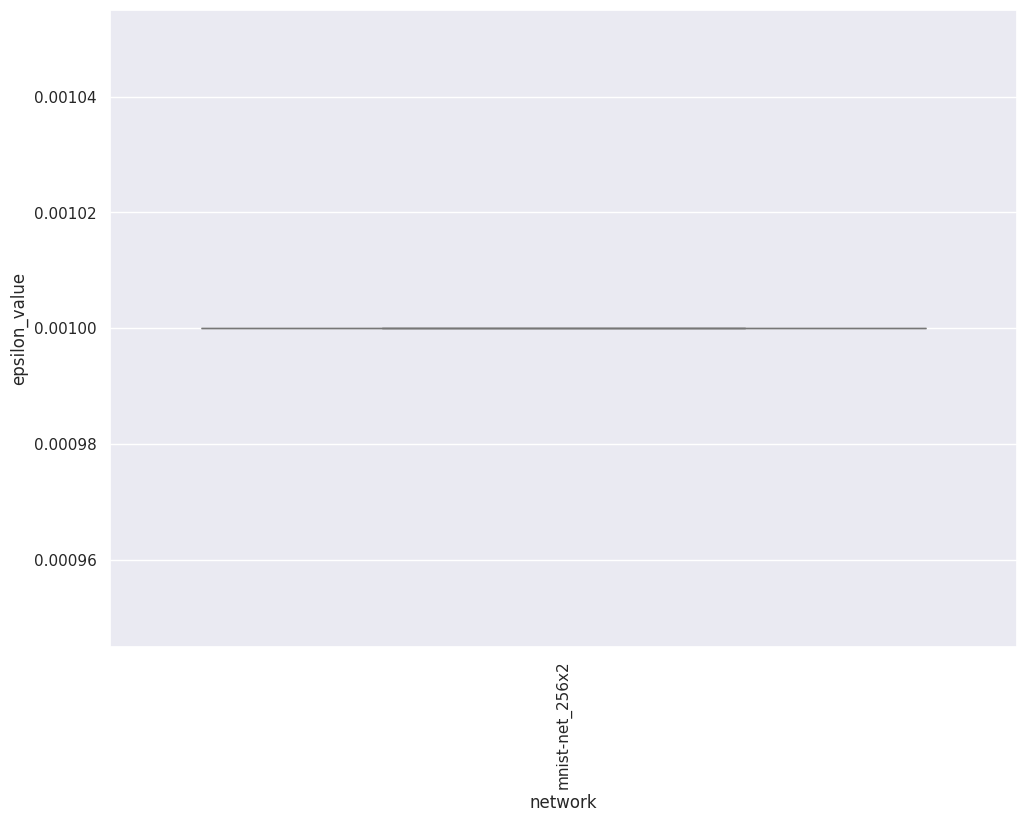

In [12]:
report_creator.create_box_figure()

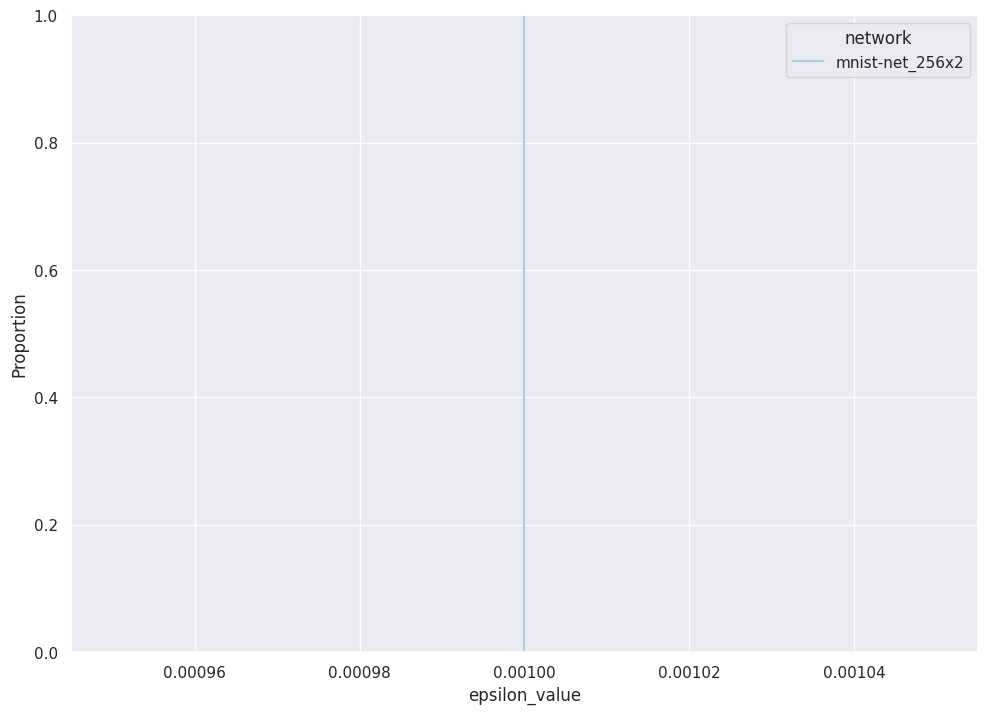

In [13]:
report_creator.create_ecdf_figure()

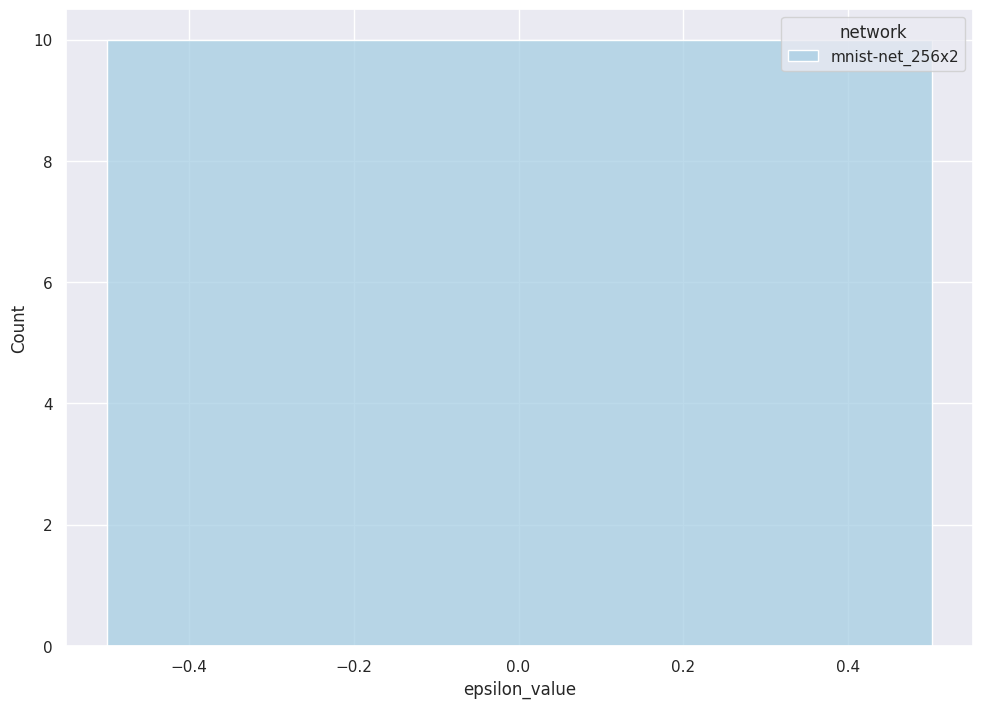

In [14]:
report_creator.create_hist_figure()

<Axes: xlabel='Epsilon values', ylabel='Fraction critical epsilon values found'>

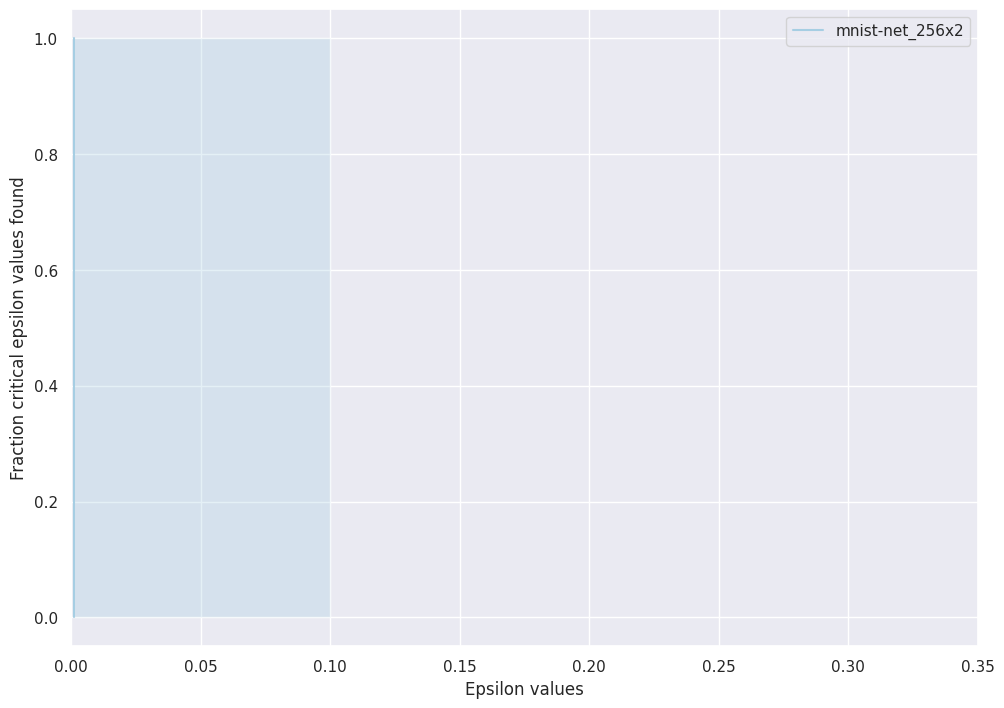

In [15]:
report_creator.create_anneplot()